In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
test_df = pd.read_csv("../Data/TestSet.csv")

In [4]:
X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

In [5]:
with open("../RandomForestModel.pkl", "rb") as f:
    model = pickle.load(f)

In [6]:
predictions = model.predict(X_test)

In [7]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1359
           1       0.94      0.91      0.93      1378

    accuracy                           0.93      2737
   macro avg       0.93      0.93      0.93      2737
weighted avg       0.93      0.93      0.93      2737

[[1277   82]
 [ 120 1258]]


In [10]:
predictions_proba = model.predict_proba(X_test)

In [11]:
predictions_proba

array([[0.10333333, 0.89666667],
       [0.17495414, 0.82504586],
       [0.02886371, 0.97113629],
       ...,
       [0.88648402, 0.11351598],
       [0.92326165, 0.07673835],
       [0.93333333, 0.06666667]])

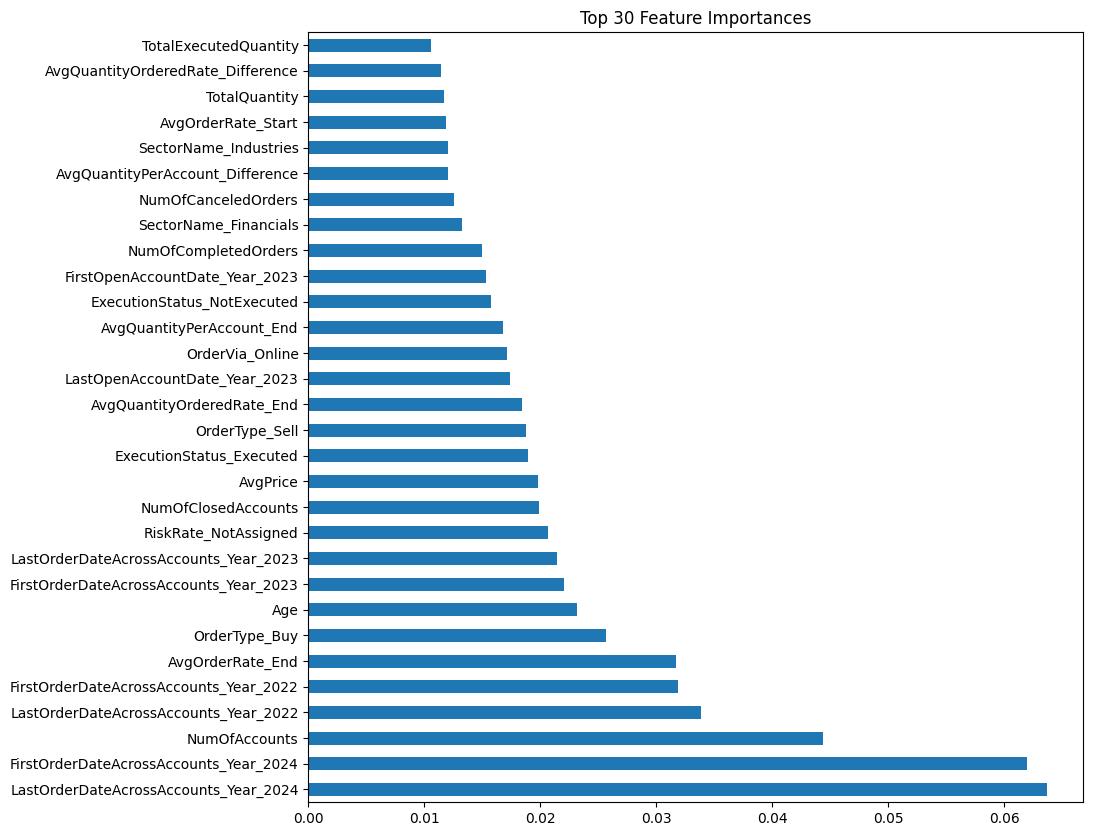

In [8]:
importances = model.feature_importances_
feature_importances = pd.Series(
    importances, index=test_df.columns[:-1]
)  # excluding the target variable
top_n = 30
top_n_importances = feature_importances.sort_values(ascending=False)[:top_n]

# Now plot the top N importances
plt.figure(figsize=(10, 10))
top_n_importances.plot(kind="barh")
plt.title("Top {} Feature Importances".format(top_n))
plt.show()

In [9]:
churn_rate = test_df["Churned"].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 50.35%


In [31]:
test_df["SecurityID_327"].unique()

array([0.])

In [32]:
correlations = (
    test_df.loc[:, (test_df != test_df.iloc[0]).any()].corr()["Churned"].sort_values()
)
print("Most Positive Correlations:\n", correlations.tail(10))
print("\nMost Negative Correlations:\n", correlations.head(10))

Most Positive Correlations:
 SecurityID_326                            0.031675
SecurityID_292                            0.033117
SecurityID_278                            0.033117
SecurityID_228                            0.033665
SecurityID_291                            0.042971
NumOfClosedAccounts                       0.244446
NumOfAccounts                             0.263444
FirstOrderDateAcrossAccounts_Year_2022    0.450288
LastOrderDateAcrossAccounts_Year_2022     0.453855
Churned                                   1.000000
Name: Churned, dtype: float64

Most Negative Correlations:
 LastOrderDateAcrossAccounts_Year_2024    -0.559975
FirstOrderDateAcrossAccounts_Year_2024   -0.546390
NumOfCompletedOrders                     -0.334558
AvgQuantityOrderedRate_End               -0.317928
NumOfCanceledOrders                      -0.316453
RiskRate_NotAssigned                     -0.314086
LastOpenAccountDate_Year_2023            -0.310410
FirstOpenAccountDate_Year_2023           -0.